In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import random

import torch
import kornia as K
import cv2 as cv

## Part A

#### Processing

In [2]:
#read image files
img_l = cv.imread('parliament-left.jpg')
img_r = cv.imread('parliament-right.jpg')

#apply zero paddings to the images to make them share the same size and be able to display the whole panorama
img_l = cv.copyMakeBorder(img_l, 100, 125, 1500, 244, cv.BORDER_CONSTANT, None, value = 0)
img_r = cv.copyMakeBorder(img_r, 200, 200, 1800, 234, cv.BORDER_CONSTANT, None, value = 0)

#the image size after zero padding
print(img_l.shape)
print(img_r.shape)

#turn images into grayscale
gray_l = cv.cvtColor(img_l, cv.COLOR_BGR2GRAY)
gray_r = cv.cvtColor(img_r, cv.COLOR_BGR2GRAY)

#The display images with zero padding
display_l = cv.cvtColor(img_l, cv.COLOR_BGR2RGB)
display_r = cv.cvtColor(img_r, cv.COLOR_BGR2RGB)

(2800, 4300, 3)
(2800, 4300, 3)


####  Detect keypoints and extract descriptors

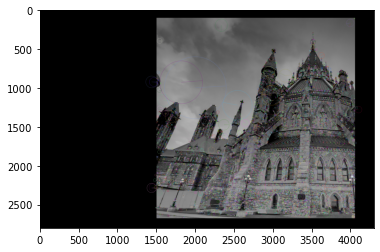

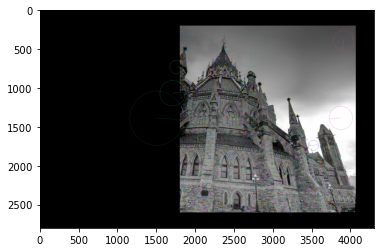

In [3]:
#computing the SIFT features for two images
sift = cv.SIFT_create()
kp_l, des_l = sift.detectAndCompute(gray_l, None)

sift = cv.SIFT_create()
kp_r, des_r = sift.detectAndCompute(gray_r, None)

#draw detected feature keypoints on image
img_l = cv.drawKeypoints(gray_l, kp_l, img_l, flags = cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img_r = cv.drawKeypoints(gray_r, kp_r, img_r, flags = cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

#save the images with features
cv.imwrite('sift_left.jpg', img_l)
cv.imwrite('sift_right.jpg', img_l)

plt.imshow(img_l)
plt.figure()
plt.imshow(img_r)

#### Match features

In [4]:
#format indexes into match array of left and right images
def format_m(indexes, kp_l, kp_r):
    matches = []
    for i in range(len(indexes)):
        x_l, y_l = kp_l[indexes[i][0]].pt
        x_r, y_r = kp_r[indexes[i][1]].pt
        matches.append([x_l, y_l, x_r, y_r])
    matches = np.array(matches, dtype = 'int')
    return matches

In [5]:
#turn detected descriptors into tensor
des_lt = torch.tensor(des_l)
des_rt = torch.tensor(des_r)

#compute the distance and indexes of feature matches
dists, indexes = K.feature.match_snn(des_lt, des_rt, 0.1)
matches = format_m(indexes, kp_l, kp_r)

#### Prune features

In [6]:
# Provided code for plotting inlier matches between two images

def plot_inlier_matches(ax, img1, img2, inliers):
    """
    Plot the matches between two images according to the matched keypoints
    :param ax: plot handle
    :param img1: left image
    :param img2: right image
    :inliers: x,y in the first image and x,y in the second image (Nx4)
    """
    res = np.hstack([img1, img2])
    ax.set_aspect('equal')
    ax.imshow(res, cmap='gray')
    
    ax.plot(inliers[:,0], inliers[:,1], '+r')
    ax.plot(inliers[:,2] + img1.shape[1], inliers[:,3], '+r')
    ax.plot([inliers[:,0], inliers[:,2] + img1.shape[1]],
            [inliers[:,1], inliers[:,3]], 'r', linewidth=0.4)
    ax.axis('off')
    
# Usage:
# fig, ax = plt.subplots(figsize=(20,10))
# plot_inlier_matches(ax, img1, img2, computed_inliers)

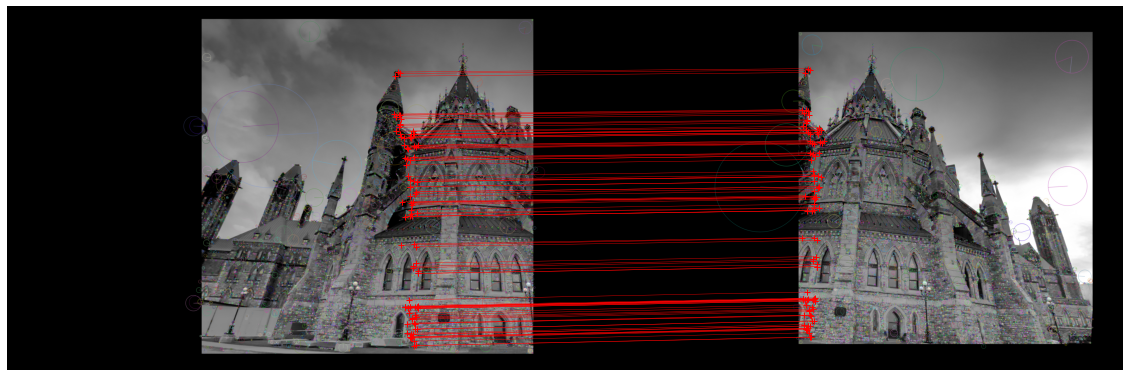

In [7]:
#plot matches founded in two images
fig, ax = plt.subplots(figsize=(20,10))
# plot the top 100 pairwise points
plot_inlier_matches(ax, img_l, img_r, matches[: 100])

#### Robust transformation estimation

In [8]:
#random a number of matches
def getRM(matches, num):
    sample = random.sample(range(len(matches)), num)
    pts = np.array(matches[sample])
    pts = pts.reshape(num, 4)
    return pts

#ransac for affine trasnformation
def affine_ransac(matches, threshold, itr):
    best_count = 0
    for i in range(itr):
        #the minimum number of paiwise points is 3 pairs of points for affine transformation
        pts = getRM(matches, 3)
        p1 = np.concatenate((pts[:, 0 : 2], np.ones((3, 1))), axis=1)
        
        #solve for transform matrix M and do the error handling to identity matrix
        try:
            M = np.linalg.solve(p1.astype(np.float32), pts[:, 2 : 4].astype(np.float32)).T
        except np.linalg.LinAlgError:
            M = np.array([[1, 0, 0], [0, 1, 0]])
            
        line3 = [0, 0, 1]
        M = np.vstack([M, line3])
        
        inliers = []
        
        for i in range(len(matches)):
            #get error distance
            error = get_h_affine(matches[i], M)
            #check if error is smaller than rho pixel, if yes it's a inlier
            if error < threshold:
                inliers.append(matches[i])
        
        count = len(inliers)
        #replace if the new dataset has more inliers
        if(count > best_count):
            most_inliers = inliers
            best_count = len(most_inliers)
            best_M = M
    #return the best inliers and the best transformation matrix
    return most_inliers, best_M

#calculate the error distance between the estimation point and the actual destination point
def get_h_affine(pair, H):
    p_l = [pair[0], pair[1], 1]
    p_r = [pair[2], pair[3], 1]
    
    p_l = np.matrix(p_l)
    p_l = np.transpose(p_l)
    p_r = np.matrix(p_r)
    p_r = np.transpose(p_r)
    
    
    est = np.dot(H, p_l)
    return np.linalg.norm(p_r - est)

#compute the final transformation matrix by least squares of all the best inliers
def least_square(inliers):
    A = []
    kp_r = []
    inliers = np.array(inliers)
    
    for i in range(len(inliers)):
        kp_l = inliers[i][0 : 2]
        kp_r.append(inliers[i][2 : 4])
        row1 = [kp_l[0], kp_l[1], 1, 0, 0, 0]
        row2 = [0, 0, 0, kp_l[0], kp_l[1], 1]
        A.append(row1)
        A.append(row2)
    
    A = np.array(A)
    kp_r = np.reshape(kp_r, (2 * len(inliers), 1))
    
    #use the pseudo inverse to get the least square solution
    M = np.linalg.pinv(A).dot(kp_r)
    M = M.reshape(2, 3)
    
    line3 = [0, 0, 1]
    M = np.vstack([M, line3])
    
    return M

In [9]:
inliers, M = affine_ransac(matches, 5, 100)

#### Compute optimal transformation

In [10]:
#apply least square to the 
M = least_square(inliers)

timg1 = K.utils.image_to_tensor(np.array(display_l), False).float() / 255.
timg2 = K.utils.image_to_tensor(np.array(display_r), False).float() / 255.
t_H = torch.from_numpy(M).unsqueeze(0)

#### Create panorama

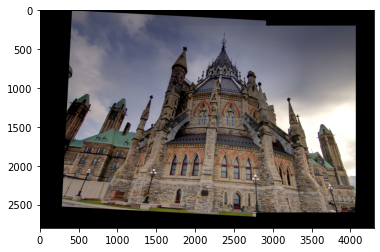

In [11]:
wrap = K.geometry.transform.warp_perspective(timg1.type(torch.double), t_H, (2800, 4300))
c = torch.maximum(wrap,timg2)

plt.imshow(K.utils.tensor_to_image(c))
plt.imsave('result_a.jpg', K.utils.tensor_to_image(c))

## part b

(5124, 9032, 3)
(5124, 9032, 3)
(5124, 9032, 3)


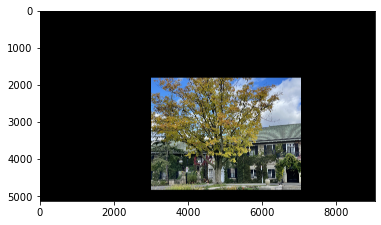

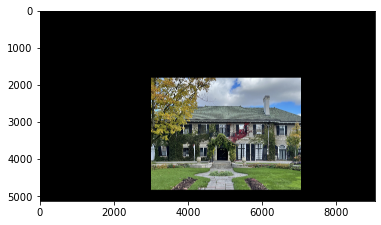

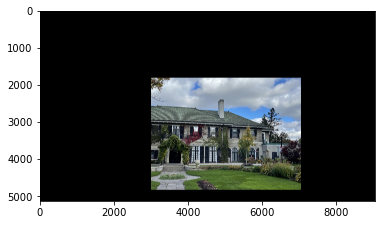

In [12]:
#read the left right middle images
img_Gl = cv.imread('Glendon-Hall-left.jpg')
img_Gm = cv.imread('Glendon-Hall-middle.jpg')
img_Gr = cv.imread('Glendon-Hall-right.jpg')

# zero padding those images
img_Gl = cv.copyMakeBorder(img_Gl, 1800, 300, 3000, 2000, cv.BORDER_CONSTANT, None, value = 0)
print(img_Gl.shape)
img_Gm = cv.copyMakeBorder(img_Gm, 1800, 300, 3000, 2000, cv.BORDER_CONSTANT, None, value = 0)
print(img_Gm.shape)
img_Gr = cv.copyMakeBorder(img_Gr, 1800, 300, 3000, 2000, cv.BORDER_CONSTANT, None, value = 0)
print(img_Gr.shape)

#store the color images for display purpose
display_Gl = cv.cvtColor(img_Gl, cv.COLOR_BGR2RGB)
display_Gm = cv.cvtColor(img_Gm, cv.COLOR_BGR2RGB)
display_Gr = cv.cvtColor(img_Gr, cv.COLOR_BGR2RGB)

#turn images into grayscale
gray_Gl = cv.cvtColor(img_Gl, cv.COLOR_BGR2GRAY)
gray_Gm = cv.cvtColor(img_Gm, cv.COLOR_BGR2GRAY)
gray_Gr = cv.cvtColor(img_Gr, cv.COLOR_BGR2GRAY)


#compute 10000 features of each images
sift = cv.SIFT_create(10000)
kp_Gl, des_Gl = sift.detectAndCompute(gray_Gl, None)

sift = cv.SIFT_create(10000)
kp_Gm, des_Gm = sift.detectAndCompute(gray_Gm, None)

sift = cv.SIFT_create(10000)
kp_Gr, des_Gr = sift.detectAndCompute(gray_Gr, None)

#draw the keypoints over the images
img_Gl = cv.drawKeypoints(gray_Gl, kp_Gl, img_Gl, flags = cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img_Gm = cv.drawKeypoints(gray_Gm, kp_Gm, img_Gm, flags = cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img_Gr = cv.drawKeypoints(gray_Gr, kp_Gr, img_Gr, flags = cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

#save the sift feature images
cv.imwrite('sift_leftG.jpg',img_Gl)
cv.imwrite('sift_middleG.jpg',img_Gm)
cv.imwrite('sift_rightG.jpg',img_Gr)

plt.imshow(display_Gl)
plt.figure()
plt.imshow(display_Gm)
plt.figure()
plt.imshow(display_Gr)

In [13]:
#store the descriptors of left and middle images
des_Glt = torch.tensor(des_Gl)
des_Gmt = torch.tensor(des_Gm)

#match the features and compute the distances and indexes
dists, indexes = K.feature.match_snn(des_Glt, des_Gmt, 0.3)
#format the matches
matches_1 = format_m(indexes, kp_Gl, kp_Gm)

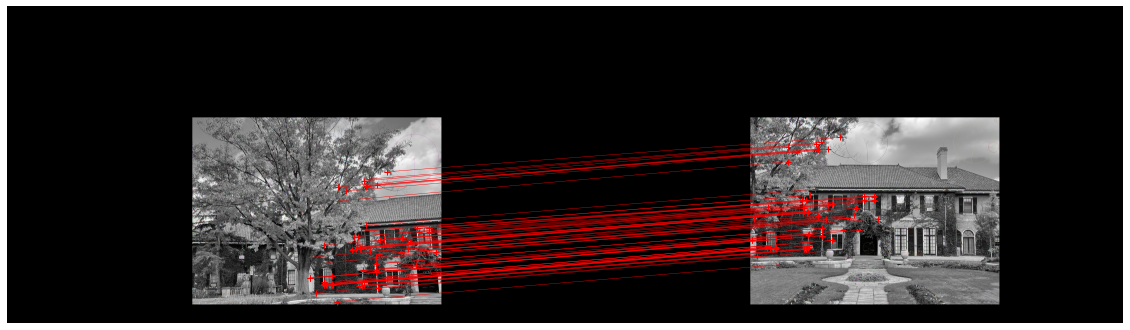

In [14]:
#show the matches founded from left and middle images
fig, ax = plt.subplots(figsize=(20,10))
plot_inlier_matches(ax, img_Gl, img_Gm, matches_1)

In [15]:
#get distance between the estimation point and the actual destination point
def get_h(pair, H):
    p_l = [pair[0], pair[1], 1]
    p_r = [pair[2], pair[3], 1]
    
    p_l = np.matrix(p_l)
    p_l = np.transpose(p_l)
    p_r = np.matrix(p_r)
    p_r = np.transpose(p_r)
    
    
    est = np.dot(H, p_l)
    #normalization of estimation coordinate
    est = (1 / est.item(2)) * est
        
    return np.linalg.norm(p_r - est)

def H_ransac(matches, threshold, itr):
    best_inliers = []
    best_H = None
    
    for i in range(itr):
        pts = getRM(matches, 4)
        H = getHomography(pts)
        
        inliers = []
        
        for i in range(len(matches)):
            error = get_h(matches[i], H)
            if error < threshold:
                inliers.append(matches[i])
        
            
        count = len(inliers)
        if(count > len(best_inliers)):
            best_inliers = inliers
            best_H = H
    
    return best_inliers, best_H

def getHomography(pairs):
    A = []
    for i in range(len(pairs)):
        kp_l = pairs[i][0 : 2]
        kp_r = pairs[i][2 : 4]
        
        row1 = [kp_l[0], kp_l[1], 1, 0, 0, 0, -kp_l[0]*kp_r[0], -kp_l[1]*kp_r[0], -kp_r[0]]
        row2 = [0, 0, 0, kp_l[0], kp_l[1], 1, -kp_l[0]*kp_r[1], -kp_l[1]*kp_r[1], -kp_r[1]]
        
        A.append(row1)
        A.append(row2)
    A = np.array(A)
    U, S, V = np.linalg.svd(A)
    
    H = np.reshape(V[len(V) - 1], (3, 3))

    # Normalization
    H = (1 / H.item(8)) * H
    return H


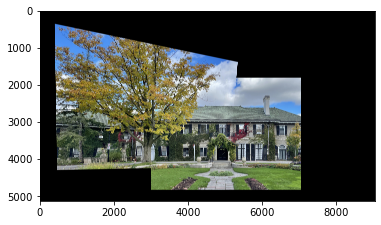

In [16]:
inliers, H = H_ransac(matches_1, 5, 1200)

timg1 = K.utils.image_to_tensor(np.array(display_Gl), False).float() / 255.
timg2 = K.utils.image_to_tensor(np.array(display_Gm), False).float() / 255.

t_H = torch.from_numpy(H).unsqueeze(0)
wrap = K.geometry.transform.warp_perspective(timg1.type(torch.double), t_H, (5124, 9032))

r1 = torch.maximum(wrap, timg2)
plt.imshow(K.utils.tensor_to_image(r1))

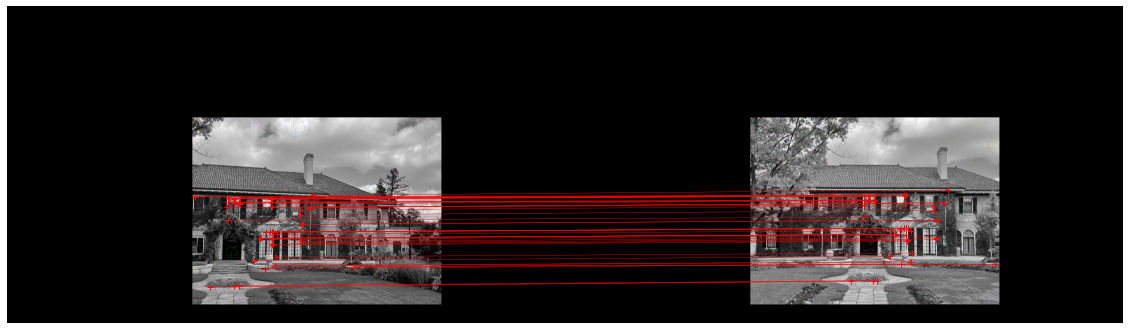

In [17]:
des_Grt = torch.tensor(des_Gr)
des_Gmt = torch.tensor(des_Gm)
dists, indexes = K.feature.match_snn(des_Grt, des_Gmt, 0.3)
matches_2 = format_m(indexes, kp_Gr, kp_Gm)
fig, ax = plt.subplots(figsize=(20,10))
#show the top 50 matches
plot_inlier_matches(ax, img_Gr, img_Gm, matches_2[:50])

In [21]:
inliers, H = H_ransac(matches_2, 5, 1200)
H = getHomography(inliers)

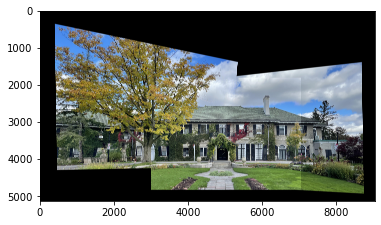

In [22]:
timg1 = K.utils.image_to_tensor(np.array(display_Gr), False).float() / 255.
timg2 = K.utils.image_to_tensor(np.array(display_Gm), False).float() / 255.

t_H = torch.from_numpy(H).unsqueeze(0)
wrap = K.geometry.transform.warp_perspective(timg1.type(torch.double), t_H, (5124, 9032))

r2 = torch.maximum(r1, wrap)
plt.imshow(K.utils.tensor_to_image(r2))

In [23]:
plt.imsave('result_b.jpg', K.utils.tensor_to_image(r2))